Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 2.1) 나무위키의 최신 변경 키워드 분석

### 바로가기

- [<Step1. 크롤링> : 크롤링으로 웹 데이터 가져오기](#<Step1.-크롤링>-:-크롤링으로-웹-데이터-가져오기)
    - [BeautifulSoup을 이용한 웹 크롤링]
    - [나무위키 최근변경 데이터 크롤링]
- [<Step2. 전처리> : 키워드 추출](#<Step2.-전처리>-:-키워드-추출)
    - [텍스트 데이터 전처리]
    - [말뭉치 만들기]
    - [konlpy를 이용한 키워드 추출]
    - [키워드 가다듬기]
- [<Step3. 시각화> : 워드 클라우드 기법](#<Step3.-시각화>-:-워드-클라우드-기법)
    - [pytagcloud 사용하기]
    - [나무위키 키워드 시각화]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. 크롤링> : 크롤링으로 웹 데이터 가져오기

### [BeautifulSoup을 이용한 웹 크롤링]

- 아래 코드 실행을 위해, anaconda prompt 혹은 터미널(cmd)에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `pip install beautifulsoup4`
    - (env_name) `pip install lxml`

##### 페이지 리스트 가져오기

In [2]:
import requests
from bs4 import BeautifulSoup
import re

source_url = "https://namu.wiki/RecentChanges"

req = requests.get(source_url)
html = req.content
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name="table", attrs={"class":"table-hover"})
table_body = contents_table.find(name="tbody")
table_rows = table_body.find_all(name="tr")

In [3]:
page_url_base = "https://namu.wiki"
page_urls = []
for index in range(0, len(table_rows)):
    first_td = table_rows[index].find_all('td')[0]
    td_url = first_td.find_all('a')
    if len(td_url) > 0:
        page_url = page_url_base + td_url[0].get('href')
        page_urls.append(page_url)

# 중복 url 제거
page_urls = list(set(page_urls))

-----

##### 페이지내 텍스트 구조 확인

In [4]:
req = requests.get(page_urls[0])
html = req.content
soup = BeautifulSoup(html, 'lxml')
title = soup.find(name="h1", attrs={"class":"title"})
category = soup.find(name="div", attrs={"class":"wiki-category"})
content_clearfix = soup.find(name="div", attrs={"class":"wiki-content clearfix"})
print(title.text)
print(category.text)
print(content_clearfix.text)


틀:안산 그리너스 FC/역대 주장


분류

대한민국의 축구클럽(틀)
안산 그리너스 FC
안산 그리너스 FC/역대 주장




    안산 그리너스 FC역대 주장   [ 펼치기 / 접기 ]초대2대3대박한수  (2017)박준희  (2018)이희성  (2019~)     




-----

### [나무위키 최근변경 데이터 크롤링]

In [5]:
columns = ['title', 'category', 'content_text']
df = pd.DataFrame(columns=columns)

for page_url in page_urls:
    req = requests.get(page_url)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    title = soup.find(name="h1", attrs={"class":"title"})
    category = soup.find(name="div", attrs={"class":"wiki-category"})
    content_clearfix = soup.find(name="div", attrs={"class":"wiki-content clearfix"})
    
    
    if title is not None:
        row_title = title.text.replace("\n", " ")
    else:
        row_title = ""
    
    if content_clearfix is not None:
        row_content_clearfix = content_clearfix.text.replace("\n", " ")
    else:
        row_content_clearfix = ""
        
    # 카테고리 데이터는 '분류'를 별도로 제거
    if category is not None:
        row_category = category.text.replace("\n", " ").replace("분류", "")
    else:
        row_category = ""
    
    row = [row_title, row_category, row_content_clearfix]
    series = pd.Series(row, index=df.columns)
    df = df.append(series, ignore_index=True)

In [6]:
df.head(5)

,title,category,content_text
0,틀:안산 그리너스 FC/역대 주장,대한민국의 축구클럽(틀) 안산 그리너스 FC 안산 그리너스 FC/역대 주장,안산 그리너스 FC역대 주장 [ 펼치기 / 접기 ]초대2대3대박한수 ...
1,덕종(고려),고려의 왕 1016년 출생 1034년 사망,고려 국왕 [ 펼치기 · 접기 ]초대제2대제3대제4대제5대태조혜종정종(定)광종경...
2,파일:gh_range_2line.png,파일/보드게임/아그리콜라,이 파일은 나무위키에서 제한된 한도 안에서 쓰입니다.본 이미지는 퍼블릭 도메인...
3,종로3가역,1974년 개업한 철도역 1985년 개업한 철도역 1996년 개업한 철도역 대...,이 문서는 나무위키 철도 프로젝트 · 나무위키 수도권 프로젝트에서 다루는 문서...
4,타오시성,중화민국의 정치인 1899년 출생 1988년 사망 후베이성 출신 인물,이 문서는 나무위키:프로젝트/중국 근현대사에서 다루는 문서입니다.해당 프로젝트...


-----

# <Step2. 전처리> : 키워드 추출

### [텍스트 데이터 전처리]

In [7]:
# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식
    result = hangul.sub('', text)
    return result

In [8]:
print(text_cleaning(content_clearfix.text))

 개요 원인 전개 경술년 년 불길한 징조 음력 정월 우박 서리 가뭄과 뒤이은 홍수 그리고 메뚜기 떼 월 윤 월 태풍과 폭우 그리고 전염병 월 구제역의 발생과 이어지는 냉우 폭풍우 대기근의 도래 신해년년 지옥도 아귀도 조정 내 상황 결과 현대에 일어날 가능성 개요편집  조선 대 현종 재위 년 년인 년 월경술년년신해년에 벌어진 년에 걸친 대기근 년 뒤인 숙종 때인 경신년 년에 일어난 일이 아니라 경술년과 신해년의 머릿자를 따 합쳐서 부르는 이름이니 유의하자 교과 과정 한국사에서 제대로 언급되지 않거나 넘어가서 잊힌 내용이지만 실상은 차라리 임진왜란 병자호란 시기가 더 나았다는 소리가 나올 정도의 참혹함이었다 조선의 역사가 년이고 전근대 사회에서 기근은 흔한 일이긴 했으나 그 점을 고려하더라도 이 때의 대기근은 그야말로 대재앙 대참사라는 단어도 부족할 정도로 끔찍했다 당시 한반도에서 일어날 수 있는 자연 재해가 대기근과 합쳐져 어마어마한 피해를 낳았기 때문이다 이후 조선 역사의 변화에도 중대한 영향을 미친 대사건이었기에 조선판 흑사병이라는 평도 있다 당시 한반도에서 일어날 수 있는 자연 재해는 하나도 빠짐없이 발생했다 원인편집세기는 지구 기온이  정도 떨어지는 소빙하기 기후가 나타난 때였다 세기 위기론 고작  정도라고 생각할 수도 있지만 정반대인 지구온난화 같은 경우에는 지구 온도가 약 만 올라가도 심각하다고 말한다인재인 지구온난화와는 달리 그 당시에는 천재인 상황이었고 실질적인 재난 대처 능력이 떨어지는 과거와 지금을 비교하는 것도 무리기에 저런 재난은 우리가 예측하는 규모보다 더 크다고 생각할 수 있다 이 소빙하기 때문에 마녀사냥이 중세가 아닌 특히 세기의 근세에 극으로 달했다는 이야기가 있을 정도다 유럽에서는 포도 수확일이 늦어졌고 평균 기온이 떨어졌으며 알프스 산맥의 빙하가 확산되고 강과 운하가 자주 얼었다 중국에서는 추위로 인해 강남 감귤 농장들이 전멸했으며 천진 운하의 결빙 기간이 늘어났다 심지어 에티오피아의 눈이 년 내내 녹지 않는 기현상이 발생하기도 

In [9]:
df['title'] = df['title'].apply(lambda x: text_cleaning(x))
df['category'] = df['category'].apply(lambda x: text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x: text_cleaning(x))
df.head(5)

,title,category,content_text
0,틀안산 그리너스 역대 주장,대한민국의 축구클럽틀 안산 그리너스 안산 그리너스 역대 주장,안산 그리너스 역대 주장 펼치기 접기 초대대대박한수 박준희 이...
1,덕종고려,고려의 왕 년 출생 년 사망,고려 국왕 펼치기 접기 초대제대제대제대제대태조혜종정종광종경종제대제대제대제대제...
2,파일,파일보드게임아그리콜라,이 파일은 나무위키에서 제한된 한도 안에서 쓰입니다본 이미지는 퍼블릭 도메인 ...
3,종로가역,년 개업한 철도역 년 개업한 철도역 년 개업한 철도역 대한민국의 도시철도 정거...,이 문서는 나무위키 철도 프로젝트 나무위키 수도권 프로젝트에서 다루는 문서입...
4,타오시성,중화민국의 정치인 년 출생 년 사망 후베이성 출신 인물,이 문서는 나무위키프로젝트중국 근현대사에서 다루는 문서입니다해당 프로젝트 문서...


-----

### [말뭉치 만들기]

In [10]:
title_corpus = "".join(df['title'].tolist())
category_corpus = "".join(df['category'].tolist())
content_corpus = "".join(df['content_text'].tolist())
print(title_corpus)

 틀안산 그리너스 역대 주장  덕종고려  파일  종로가역  타오시성  파일키라판블렌드  브니엘중학교     헤이스팅스 전투  홍우진페북스타  라이더차행적  후지타 사유리  장유동  형원열애설 논란  세라 천사  루리웹비판  콩원피스  박신지  혁신학교   식품     이형범  연애의 맛  유상훈  샤잠  미쯔비시 식 특대형트럭  나무위키프로젝트정당  년 고성속초 산불    아우디   프리미어 리그 시즌  지하 경제  유채영활동 내역  크라켄 마이너소어  파일수영복 카호 성 진화  차 양광사변  여덟 손가락  백워즈  쉐보레 크루즈        태양의 계절  파일수영복 카호 성  구멍위  해럴드 세  나는 약이다 시리즈  중산함 사건  돌고래  브래드 암스트롱  파일무모편 권  오버워치   시즌 강결승  편견 및 고정관념사회  프링글스  파일유채영  아싸  하스스톤카드일람어둠의 반격일반 등급  만악의 근원창작물  우치다 아야  인구 절벽  자동 정제소  롯데 자이언츠년월  범죄자목록아시아       하치스카 큐인  틀 리그 응원가  플라튼각성  붕괴세계관기숙사 스토리  순호  강호철  중요하니까 두 번 말했습니다  문서 사유화  마녀클래시 로얄  그리스 왕국   마운틴듀     경신대기근 


-----

### [konlpy를 이용한 키워드 추출]

- 아래 코드 실행을 위해, anaconda prompt 혹은 터미널(cmd)에서 아래와 같은 패키지들을 설치해 줍니다.
- 아래의 방법으로 설치해도 실행되지 않는다면, http://konlpy.org/ko/latest/install/ 를 참고하세요.
    - Mac OS, Linux
        - 1. Java SDK를 설치합니다.
        - 2. 아래와 같은 파이썬 패키지를 설치합니다.
            - (env_name) `pip install konlpy`
            - (env_name) `pip install jpype1`
            - (env_name) `pip install Jpype1-py3`
    - windows
        - ???

In [11]:
from konlpy.tag import Twitter
from collections import Counter

nouns_tagger = Twitter()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)

In [12]:
count

Counter({'안산': 2,
         '스': 64,
         '역대': 33,
         '주장': 196,
         '접기': 34,
         '초대': 20,
         '박한수': 1,
         '박준희': 1,
         '이희성': 1,
         '고려': 47,
         '국왕': 18,
         '대제': 14,
         '태조': 2,
         '혜종': 1,
         '정종': 2,
         '광종': 1,
         '경종': 1,
         '제대': 11,
         '성종': 6,
         '목종': 1,
         '현종': 91,
         '덕종': 24,
         '문종': 3,
         '순종': 3,
         '선종': 2,
         '헌종': 1,
         '숙종': 8,
         '예종': 4,
         '인종': 11,
         '의종': 2,
         '명종': 1,
         '신종': 2,
         '임시': 16,
         '희종': 1,
         '강종': 1,
         '고종': 2,
         '원종': 3,
         '영종': 1,
         '충렬왕': 1,
         '충선왕': 1,
         '충숙왕': 1,
         '충혜왕': 1,
         '충목왕': 1,
         '충정왕': 1,
         '공민왕': 1,
         '우왕': 1,
         '창왕': 1,
         '공양왕': 1,
         '추존': 1,
         '국조': 2,
         '의조': 1,
         '세조': 1,
         '대종': 1,
         '안종': 1,
    

-----

### [키워드 가다듬기]

##### 한글자 키워드 제거

In [13]:
# 한글자 키워드 제거
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'때문': 1134, '경우': 1109, '편집': 1095, '사람': 1025, '자신': 619, '정도': 544, '사실': 532, '이후': 523, '문제': 513, '경기': 501, '대한': 441, '다른': 437, '시간': 431, '상황': 398, '생각': 397, '이름': 382, '게임': 380, '시작': 379, '문서': 377, '사용': 376, '공격': 370, '학교': 364, '하나': 360, '회복': 358, '한국': 357, '위해': 349, '관련': 346, '중학교': 325, '이유': 320, '또한': 318, '사건': 317, '시즌': 315, '대해': 308, '체력': 300, '해당': 299, '기록': 297, '부산': 290, '모두': 289, '모습': 289, '가장': 286, '정신': 282, '당시': 281, '가지': 281, '자체': 278, '일본': 278, '루리웹': 272, '다시': 269, '이상': 266, '시리즈': 264, '상태': 262, '사회': 261, '존재': 252, '지역': 250, '브니엘': 249, '자기': 246, '매우': 242, '선수': 242, '모든': 241, '결과': 241, '실제': 240, '인간': 239, '거점': 233, '장제스': 222, '인구': 220, '추가': 219, '카드': 219, '상대': 217, '다음': 214, '다만': 214, '역시': 212, '거의': 211, '세계': 206, '이전': 205, '발생': 205, '내용': 203, '전투': 203, '바로': 202, '돌고래': 202, '이용': 201, '유저': 199, '오히려': 198, '등장': 198, '군대': 197, '주장': 196, '대부분': 196, '수준': 194, '수도': 190, '국가': 189, '라운드': 188,

-----

##### 불용어 제거

In [14]:
# 한국어 약식 불용어사전 예시 (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "../data/korean_stopwords.txt"

with open(korean_stopwords_path) as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [15]:
# 나무위키 페이지에 맞는 불용어 추가하기
namu_wiki_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장'
                       '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물', 
                       '이름', '년월']
for stopword in namu_wiki_stopwords:
    stopwords.append(stopword)

In [16]:
# 불용어 제거
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})
print(remove_char_counter)

Counter({'사람': 1025, '문제': 513, '경기': 501, '대한': 441, '게임': 380, '시작': 379, '공격': 370, '학교': 364, '회복': 358, '한국': 357, '위해': 349, '관련': 346, '중학교': 325, '이유': 320, '사건': 317, '시즌': 315, '대해': 308, '체력': 300, '기록': 297, '부산': 290, '가장': 286, '정신': 282, '당시': 281, '가지': 281, '자체': 278, '일본': 278, '루리웹': 272, '다시': 269, '시리즈': 264, '상태': 262, '사회': 261, '존재': 252, '지역': 250, '브니엘': 249, '선수': 242, '결과': 241, '실제': 240, '인간': 239, '거점': 233, '장제스': 222, '인구': 220, '카드': 219, '상대': 217, '역시': 212, '세계': 206, '이전': 205, '발생': 205, '전투': 203, '돌고래': 202, '이용': 201, '유저': 199, '등장': 198, '군대': 197, '주장': 196, '대부분': 196, '수준': 194, '수도': 190, '국가': 189, '라운드': 188, '지금': 186, '방송': 185, '피해': 184, '현재': 183, '허기': 180, '마지막': 179, '참고': 179, '그녀': 177, '호선': 176, '능력': 176, '투수': 176, '기사': 174, '미국': 172, '재료': 172, '본인': 171, '비판': 170, '악의': 170, '일반': 169, '유채영': 167, '기준': 164, '계속': 163, '이기': 162, '스킬': 162, '일부': 160, '안타': 159, '통해': 158, '부분': 158, '시절': 156, '정부': 156, '이닝': 156, '

-----

# <Step3. 시각화> : 워드 클라우드 기법

### [pytagcloud 사용하기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 터미널(cmd)에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `pip install pytagcloud pygame simplejson`
    - (env_name) `pip install webbrowser`
- 그리고 아래와 같은 경로에 한글 폰트(예: NanumBarunGothic.ttf) 파일을 옮깁니다.
    - Mac OS : /anaconda/envs/{env_name}/lib/python3.7/site-packages/pytagcloud/fonts
    - Windosw OS : C:\Users\USER\Anaconda3\envs\pc37 (env_name) \Lib\site-packages\pytagcloud\fonts
- 파일을 옮긴 후, 파이썬 가상환경을 재실행 하여 주피터를 다시 실행해줍니다. 그래도 아래의 코드가 실행되지 않는 경우는 다음과 같은 작업을 수행합니다.
    - 위의 경로에서 font.json 파일을 편집합니다.
    - 아래와 같은 코드를 추가합니다.
    - {
                "name": "NanumGothic",
                "ttf": "NanumGothic.ttf",
                "web": "http://fonts.googleapis.com/css?family=Nanum+Gothic"
        },

In [17]:
import random
import pytagcloud
import webbrowser

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


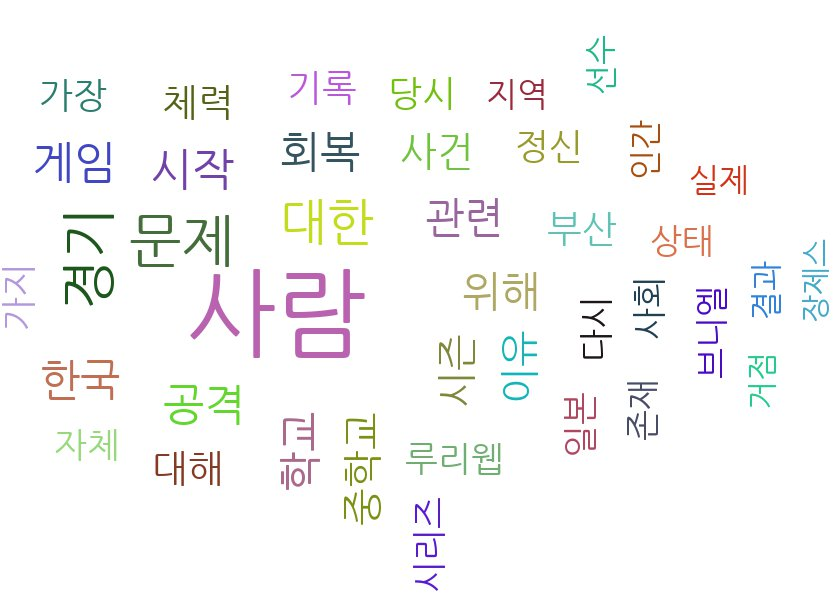

In [18]:
from IPython.display import Image
Image(filename='wordcloud.jpg')

-----

### [나무위키 키워드 시각화]

##### 제목 키워드

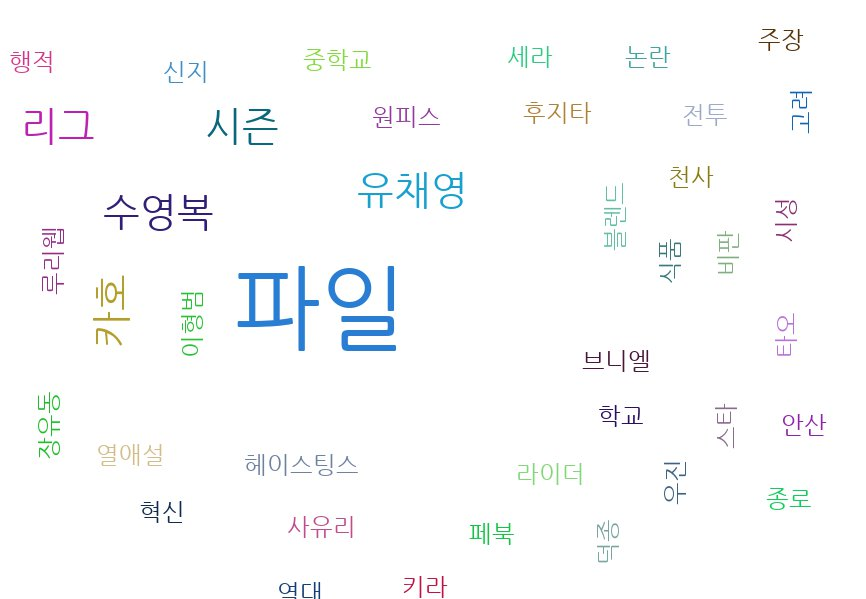

In [19]:
nouns_tagger = Twitter()
nouns = nouns_tagger.nouns(title_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'title_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='title_wordcloud.jpg')

-----

##### 카테고리 키워드

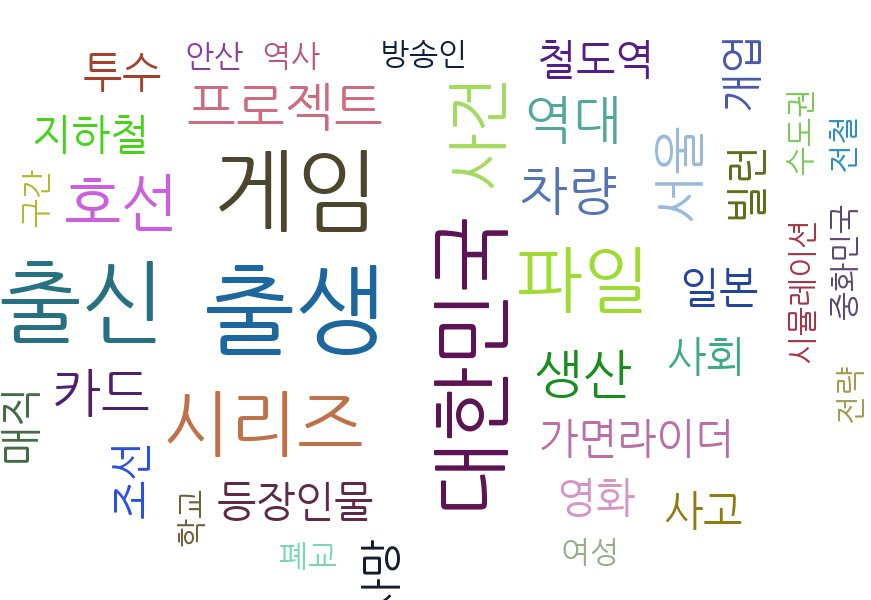

In [20]:
nouns_tagger = Twitter()
nouns = nouns_tagger.nouns(category_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'category_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='category_wordcloud.jpg')